# Set up

In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
from numpy.random import seed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28643 sha256=03a7c52af5d10800f849c1aa23f338ca2887728aec4569b8c75f2024c0f920a1
  Stored in directory: /root/.cache/pip/wheels/df/33/51/592213372072da189a4ff8f471838cadcc91add5821f7b9b38
Successfully built yahoofinancials


<ipython-input-1-b19db403f2c8>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
seed(1)
tf.random.set_seed(2)

In [ ]:
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict :
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame :
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

# Get the data

In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'IBM'
# Choose a date range
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x : datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')
stock['Symbol'] = symbol_to_fetch
stock.tail()
#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch

stock['Close'].tail()

DateTime
2023-04-10 13:30:00    131.029999
2023-04-11 13:30:00    130.419998
2023-04-12 13:30:00    128.539993
2023-04-13 13:30:00    127.900002
2023-04-14 13:30:00    128.139999
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
symbol_to_fetch = 'IBM'
# Choose a date range
start_date = str(datetime(2018, 1, 1).date())
end_date = str(datetime(2022, 12, 31).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

In [ ]:
train_start_date = start_date
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'
training_set = stock[train_start_date : train_end_date].iloc[:, 3 : 4].values 
test_set = stock[test_start_date :].iloc[:, 3 : 4].values

test_set_return = stock[test_start_date:].iloc[:, 3 : 4].pct_change().values

print(training_set.shape)
print(test_set.shape)

(756, 1)
(71, 1)


# Discover and visualize the data to gain insights

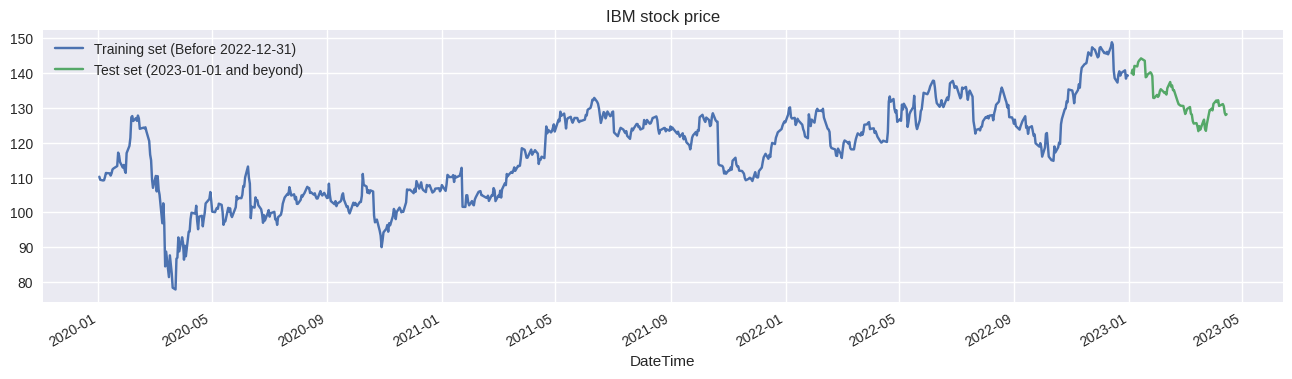

In [ ]:
target = 'Close'
stock[target][train_start_date : train_end_date].plot(figsize=(16, 4),legend=True)
stock[target][test_start_date :].plot(figsize=(16, 4),legend=True)
plt.legend([f'Training set (Before {train_end_date})', f'Test set ({test_start_date} and beyond)'])
plt.title(f'{symbol_to_fetch} stock price')
plt.show()

# Prepare the data for Machine Learning algorithms

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
timesteps = 8

x_train = []
y_train = []
for i in range(timesteps, training_set.shape[0]):
    x_train.append(training_set_scaled[i - timesteps : i, 0])
    y_train.append(training_set_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[0.45602242 0.44360435 0.44084483 0.44187962 0.45475776 0.47119991
 0.47062497 0.46959006] 0.4606216655038431
[0.44360435 0.44084483 0.44187962 0.45475776 0.47119991 0.47062497
 0.46959006 0.46062167] 0.46982036477957334


In [ ]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(748, 8) (748,)
(748, 8, 1) (748,)


In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# Build and train the model 

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    # EMBEDDING LAYER
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    
    # ATTENTION LAYER
    x = layers.MultiHeadAttention(
        key_dim = head_size, 
        num_heads = num_heads, 
        dropout = dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
) :
    inputs = keras.Input(shape = input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks) : 
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units :
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs = 30, decay_epochs = 100, initial_lr = 1e-6, base_lr = 1e-3, min_lr = 5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model = build_model(
    input_shape,
    head_size = 46, # Embedding size for attention
    num_heads = 60, # Number of attention heads
    ff_dim = 55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks = 5,
    mlp_units = [256],
    mlp_dropout = 0.4,
    dropout = 0.14,
)

model.compile(
    loss = "mean_squared_error",
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 20,
    callbacks = callbacks,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        19321       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

# Evaluate the model

3/3 [==============================] - 1s 29ms/step
[128.53999329] [127.90000153] [128.13999939]
[130.41999817] [128.53999329] [127.90000153]
[129.36215]


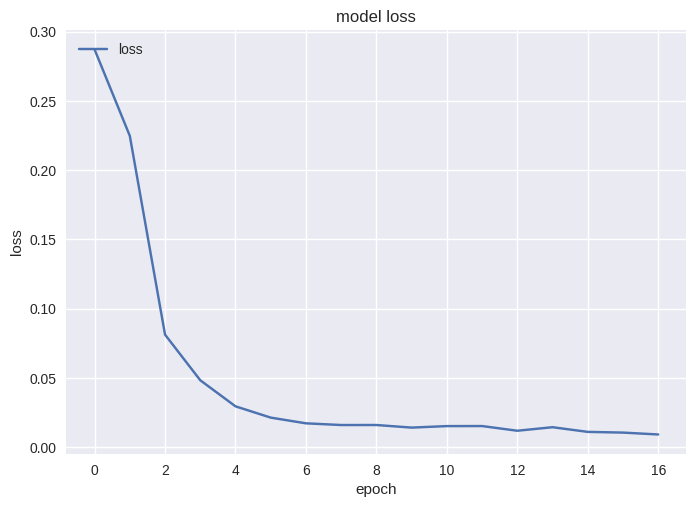

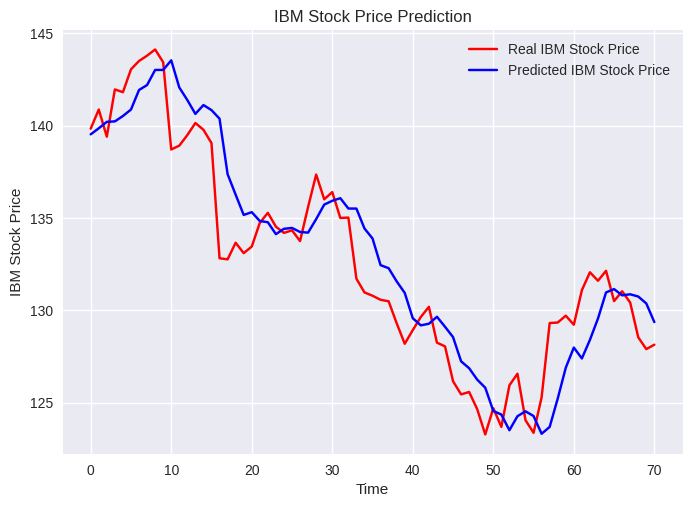

The root mean squared error is 2.259505148242672.


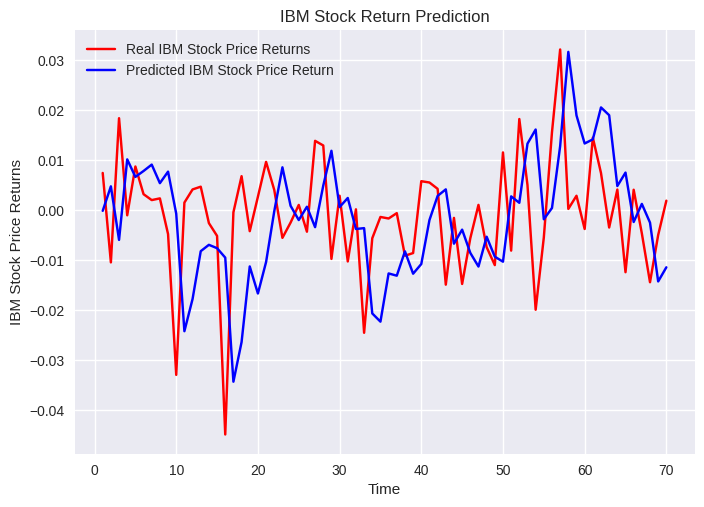

The root mean squared error is 0.015829875017786616.


0.015829875017786616

In [ ]:
dataset_total = pd.concat((original_stock[target][: train_end_date], original_stock[target][test_start_date :]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - timesteps :].values
inputs = inputs.reshape(-1, 1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps, test_set.shape[0] + timesteps):
    X_test.append(inputs[i - timesteps : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) 
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set, predicted_stock_price, original_symbol)
return_rmse(test_set, predicted_stock_price)

plot_return_predictions(test_set_return, predicted_return, original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])